## Load packages
Firstly, we load the necessary packages for the code to run

In [1]:
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import NMF

from random import sample

import copy
from functions import plotsigs, cosine_perm, simulate_counts
from NMFAE_init import NMFAE, train_NMFAE
from optuna_opt import optuna_tune
from torch import optim

[I 2022-02-16 14:53:48,794] A new study created in memory with name: no-name-8d32441d-3abf-4733-b440-96402d2c3ca1
[I 2022-02-16 14:53:49,635] Trial 0 finished with value: 9.176970815658569 and parameters: {'lr': 0.0002813341079881897, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 0 with value: 9.176970815658569.
[I 2022-02-16 14:53:50,586] Trial 1 finished with value: 1.2294230103492736 and parameters: {'lr': 0.0048796219484371186, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 1.2294230103492736.
[I 2022-02-16 14:53:51,212] Trial 2 finished with value: 25.8677978515625 and parameters: {'lr': 6.654990515421048e-05, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 1 with value: 1.2294230103492736.


{'lr': 0.0048796219484371186, 'batch_size': 32, 'optimizer': 'RMSprop'}


## Split data
Firstly we write a method to split the mutational profile matrix into a training and validation set.

In [2]:
def split_data(data, frac_1, frac_2):
  x_tuning = data.sample(frac = frac_1)
  data_new = data.drop(x_tuning.index)
  x_train = data_new.sample(frac=frac_2)
  x_val = data.drop(x_train.index)
  return x_tuning, x_train, x_val

# NMF performance

In [3]:
def out_errorNMF(train_df, validation_df, nsigs ,true_sigs):
  model = NMF(n_components=nsigs, init='random', max_iter = 500)
  exposures = model.fit_transform(train_df)
  signatures = model.components_
  
  cos_NMF = cosine_perm(true_sigs.to_numpy().transpose(), signatures)[0]
  cos_mean = np.mean(cos_NMF.diagonal())


  ref_exposures = model.transform(X = validation_df)
  rec = np.dot(ref_exposures, signatures)
  MSE = np.mean(((validation_df - rec)**2).to_numpy())

  return([cos_mean, MSE])

# AAUtoSig performance

In [4]:
def out_errorAE(tuning_df, train_df, validation_df, nsigs, true_sigs):
  params = optuna_tune(tuning_df, nsigs)
  lr = params['lr']
  batch_size = params['batch_size']
  optimizer_name = params['optimizer']
  model = NMFAE(dim1 = nsigs)

  # Validation using MSE Loss function
  loss_function = torch.nn.MSELoss(reduction='mean')

  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

                              
  train_NMFAE(epochs = 500, 
                model = model, 
                x_train = train_df, 
                loss_function = loss_function, 
                optimizer = optimizer,
                batch_size = int(batch_size)
)

  W = model.dec1.weight.data    
  W_array = W.numpy()

  cos_AE = cosine_perm(true_sigs.to_numpy().transpose(),W_array.transpose())[0]
  cos_mean = np.mean(cos_AE.diagonal())

  x_validation_tensor = torch.tensor(validation_df.values, 
                                      dtype = torch.float32)
  rec = model(x_validation_tensor)
  MSE = (float(loss_function(rec,x_validation_tensor).detach().numpy()))

  return([cos_mean, MSE])

## Performance analysis

In [ ]:
%%capture
def performance_analysis(npatients, nsigs):
  mut_matrix, signatures, _ = simulate_counts(nsigs, npatients)
  tuning_data, train_data, validation_data = split_data(mut_matrix.transpose(), 0.5, 0.8)
  return(out_errorNMF(train_data, validation_data, nsigs, signatures) + out_errorAE(tuning_data, train_data, validation_data, nsigs, signatures))
asd = np.array([performance_analysis(4000, 5) for _ in range(100)])
result = pd.DataFrame(asd)
result.columns = ["cosineNMF", "outNMF", "cosineAE", "outAE"]


[I 2022-02-16 14:57:43,868] A new study created in memory with name: no-name-c6e8e16f-f176-4e15-9cb6-a50b2b0a01e8
[I 2022-02-16 14:57:46,169] Trial 0 finished with value: 28.897503471374513 and parameters: {'lr': 3.623664137227159e-05, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 0 with value: 28.897503471374513.
[I 2022-02-16 14:57:47,835] Trial 1 finished with value: 6.462489795684815 and parameters: {'lr': 0.0235158411121356, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 6.462489795684815.
[W 2022-02-16 14:57:48,867] Trial 2 failed, because the objective function returned nan.
[I 2022-02-16 14:57:49,700] A new study created in memory with name: no-name-e951b22b-e3b7-43a3-9ea0-5dba6c46787c
[I 2022-02-16 14:57:51,193] Trial 0 finished with value: 1.775515878200531 and parameters: {'lr': 0.0063827836189783715, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 1.775515878200531.
[W 2022-02-16 14:57:52,134] Trial 1 failed, because the

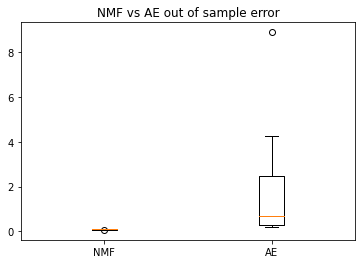

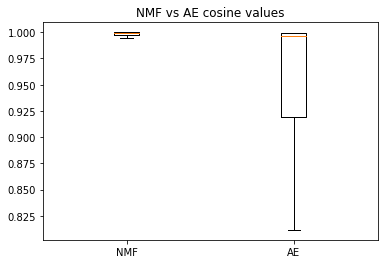

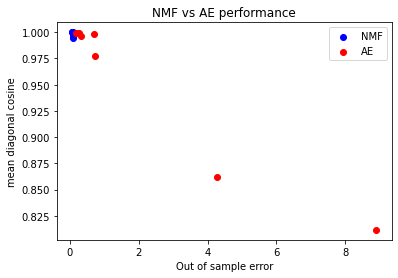

In [7]:
plt.boxplot(result[['outNMF', 'outAE']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error')
plt.show()

plt.boxplot(result[['cosineNMF', 'cosineAE']],labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values')
plt.show()

plt.scatter(y = result['cosineNMF'], x = result['outNMF'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE'], x = result['outAE'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance')
plt.legend()
plt.show()